In [2]:
import os
import pickle
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from IPython.core.display import HTML
from IPython.display import SVG, Image, display

#RDKit related imports
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import Draw

#scikit imports
from sklearn.model_selection import train_test_split

#tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate

#set to CRITICAL to avoid all the warning messages
RDLogger.logger().setLevel(RDLogger.CRITICAL)

unused_descriptors = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']

desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in unused_descriptors])

In [3]:
def show(df):
    return HTML(df.to_html(notebook=True))

In [4]:
#set TF to warnings & errors
tf.get_logger().setLevel('INFO')

In [5]:
#check for GPUs
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12336680143837147808
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5409865728
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5673292614290321540
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-06-27 16:25:04.710085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 16:25:04.734981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 16:25:04.738873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 16:25:04.738988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
# #create list of active compounds from the CSV
# import csv

# csv_filename = 'AID_1511_datatable_all.csv'

# CIDs = []
# activities = []

# with open(csv_filename, 'r') as csvfile:
#     reader = csv.reader(csvfile)
#     readflag = False
#     headers = []
#     for ID, line in enumerate(reader):
#         if ID == 0:
#             #headers
#             headers.append(line)
#             continue
#         if ID < 5:
#             continue

#         CID = int(line[2])
#         activity = str(line[3])

#         CIDs.append(CIDs)
#         activities.append(activities)

# print(len(CIDs))
# print(len(activities))


    

In [7]:
# assert len(CIDs) == len(activities)

In [8]:
assay = 1511

In [9]:
#nvm this does everything
sdf_path = os.path.join(os.getcwd(), '1511_compounds.sdf')

dataset = PandasTools.LoadSDF(sdf_path)

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,

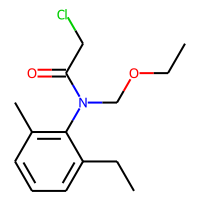
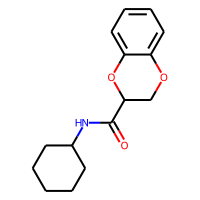
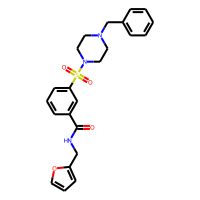
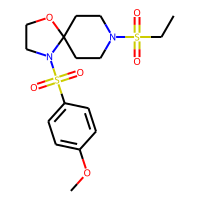

In [ ]:
show(dataset.head(4))

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol
4890,1511,56315515,17178962,Active,C1COCCN1S(=O)(=O)C2=CC=C(C=C2)NC(=O)CCC3=CC=CC...,,
4945,1511,56319046,24687034,Active,CCOC1=CC(=C(C=C1NC(=O)CN2C(=C(C(=N2)C)[N+](=O)...,,

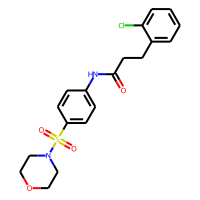
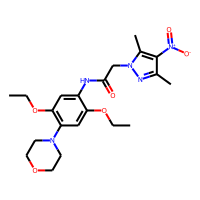

In [ ]:
#remove inactive compounds
active_compounds = dataset[dataset["PUBCHEM_ACTIVITY_OUTCOME"] == 'Active']

show(active_compounds.head(2))

In [ ]:
# active_SMILES = active_compounds["PUBCHEM_CANONICAL_SMILES"].to_list()

In [ ]:
#remove weird shit
init_len = active_compounds.shape[0]
for index, i in active_compounds.iterrows():
    try:
        mol = Chem.MolFromSmiles(i["PUBCHEM_CANONICAL_SMILES"])
    except:
        active_compounds.drop(i)

diff = init_len - active_compounds.shape[0]
print(f'{diff} compounds removed from Active list, list now has {active_compounds.shape[0]} compounds remaining.')
        

0 compounds removed from Active list, list now has 1552 compounds remaining.


In [ ]:
smi_train, smi_test = train_test_split(active_compounds["PUBCHEM_CANONICAL_SMILES"], random_state=20)

print(smi_train.shape)
print(smi_test.shape)

(1164,)
(388,)


In [ ]:
charset = set("".join(list(active_compounds.PUBCHEM_CANONICAL_SMILES)) + '!E')

#char to int dic
char2int = dict((char, int) for int, char in enumerate(charset))
#int to char
int2char = dict((int, char) for int, char in enumerate(charset))

In [ ]:
max_length = max([len(smile) for smile in active_compounds.PUBCHEM_CANONICAL_SMILES]) + 5

In [ ]:
print(f'{len(charset)}, {max_length}')

29, 105


In [ ]:
def oneH_mat_xy(smiles, charset, max_length=50):
    """
    Creates 3D matrix of (dataset length) X (longest smiles str) X (length of charset)
    Returns two 3D matrices, x starting from !, y from one char further along
    """
    one_hot = np.zeros((smiles.shape[0], max_length, len(charset)))
    #now iterate over the smiles strings
    for ID, i in enumerate(smiles):
        #set initial vec to be !
        one_hot[ID, 0, char2int["!"]] = 1
        for ID_2, j in enumerate(i):
            #encode the other digits in the vec
            one_hot[ID, ID_2+1, char2int[j]] = 1
        #encode end char
        one_hot[ID, len(i) + 1:, char2int["E"]] = 1
    #return x & y, where y is shifted one char along
    return one_hot[:, 0:-1, :], one_hot[:, 1:, :]


In [ ]:
x_train, y_train = oneH_mat_xy(smi_train.values, charset, max_length=max_length)
x_test, y_test = oneH_mat_xy(smi_test.values, charset, max_length=max_length)

In [110]:
# #alternate method
# full_string = "\n".join(list(active_compounds.PUBCHEM_CANONICAL_SMILES))


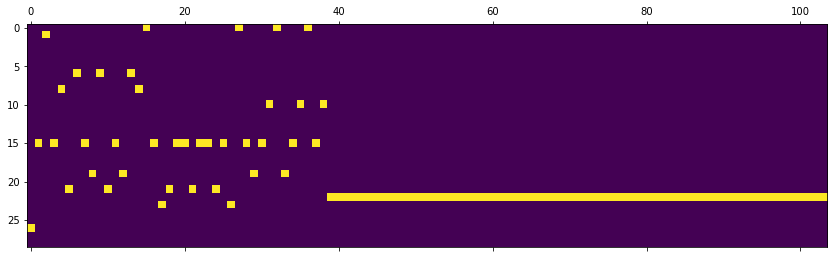

In [17]:
test_vec = x_train[0]

plt.matshow(test_vec.T)

In [ ]:
#attempt to use the paper approach
# 'Generative Recurrent Networks for De Novo Drug Design'

In [1]:
print(x_train.shape)

NameError: name 'x_train' is not defined

In [58]:
input_dim = x_train.shape[1:]
output_dim = y_train.shape[-1]

latent_dim = 1028
lstm_dim = 1028

In [59]:
inputs = Input(shape=input_dim)
#setup 1st LSTM layer
mol_enc = LSTM(latent_dim, return_state=True, unroll=False)
#get outputs
outputs, state_h, state_c = mol_enc(inputs)
#maybe include a dropout layer idk?

#concatenate states
states = Concatenate(axis=-1)([state_h, state_c])

ch_concat = Dense(latent_dim, activation='relu')
ch_outputs = ch_concat(states)

In [60]:
dec_h = Dense(latent_dim, activation='relu')
dec_c = Dense(latent_dim, activation='relu')

H_decoded = dec_h(ch_outputs)
C_decoded = dec_c(ch_outputs)

encoder_states = [H_decoded, C_decoded]

decoder_inputs = Input(shape=input_dim)
decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=False)

dec_out = decoder_lstm(decoder_inputs, initial_state=encoder_states)
dec_dense = Dense(output_dim, activation='softmax')
dec_out = dec_dense(dec_out)

model = Model([inputs, decoder_inputs], dec_out)
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 104, 29)]    0           []                               
                                                                                                  
 lstm_8 (LSTM)                  [(None, 1028),       4350496     ['input_9[0][0]']                
                                 (None, 1028),                                                    
                                 (None, 1028)]                                                    
                                                                                                  
 concatenate_3 (Concatenate)    (None, 2056)         0           ['lstm_8[0][1]',                 
                                                                  'lstm_8[0][2]']           

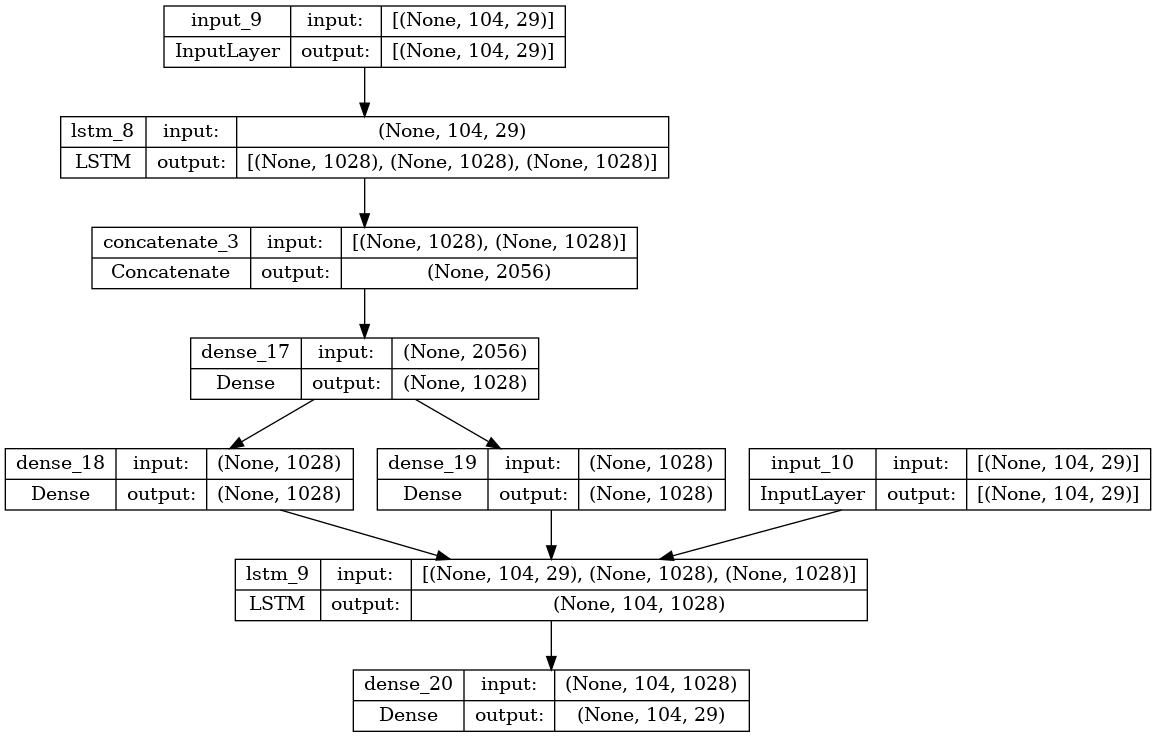

In [61]:
image_model = tf.keras.utils.plot_model(model, f"{assay}_de_novo_generator.png", show_shapes=True)
display(Image(filename=f"{assay}_de_novo_generator.png"))

In [62]:
from tensorflow.keras.callbacks import History, ReduceLROnPlateau
h = History()
red_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1, min_delta=1e-8)

In [63]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.05)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [64]:
model.fit([x_train,x_train],y_train,
                    epochs=300,
                    batch_size=5,
                    shuffle=True,
                    callbacks=[h, red_LR],
                    validation_data=[[x_test,x_test],y_test])

Epoch 1/300
233/233 [==============================] - 9s 33ms/step - loss: 2.8300 - val_loss: 1.7687 - lr: 0.0500
Epoch 2/300
233/233 [==============================] - 7s 31ms/step - loss: 4.2186 - val_loss: 3.5459 - lr: 0.0500
Epoch 3/300
233/233 [==============================] - 7s 31ms/step - loss: 2.0566 - val_loss: 1.8556 - lr: 0.0500
Epoch 4/300
233/233 [==============================] - 7s 31ms/step - loss: 2.2333 - val_loss: 3.0809 - lr: 0.0500
Epoch 5/300
233/233 [==============================] - 7s 31ms/step - loss: 5.4897 - val_loss: 2.5376 - lr: 0.0500
Epoch 6/300
233/233 [==============================] - 7s 31ms/step - loss: 1.8241 - val_loss: 1.6257 - lr: 0.0500
Epoch 7/300
233/233 [==============================] - 7s 31ms/step - loss: 2.0981 - val_loss: 2.6307 - lr: 0.0500
Epoch 8/300
233/233 [==============================] - 7s 31ms/step - loss: 4.4657 - val_loss: 2.1262 - lr: 0.0500
Epoch 9/300
233/233 [==============================] - 7s 31ms/step - loss: 1.92

In [65]:
#decoder model
import pickle
pickle.dump(h.history, open('RNN_history.p', 'wb'))

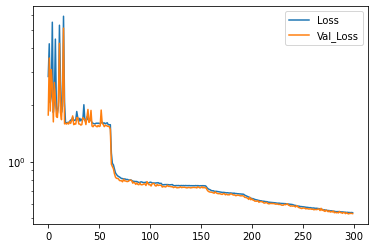

In [66]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

In [67]:
smiles_to_latent = Model(inputs, ch_outputs)
smiles_to_latent.save('smi2lat.h5')

In [68]:
latent_input = Input(shape=(latent_dim, ))

state_h_decoded_2 = dec_h(latent_input)
state_c_decoded_2 = dec_c(latent_input)
latent_to_states = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states.save('lat2state.h5')

In [74]:
inf_decoder_inputs = Input(batch_shape=(1,1, input_dim[1]))

inf_decoder_lstm = LSTM(latent_dim,return_sequences=True, unroll=False, stateful=True)

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
test_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [75]:
#transfer weights
for i in range(1,3):
    test_model.layers[i].set_weights(model.layers[i+6].get_weights())
test_model.save('test_model.h5')

In [77]:
test_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(1, 1, 29)]              0         
                                                                 
 lstm_12 (LSTM)              (1, 1, 1028)              4350496   
                                                                 
 dense_23 (Dense)            (1, 1, 29)                29841     
                                                                 
Total params: 4,380,337
Trainable params: 4,380,337
Non-trainable params: 0
_________________________________________________________________


In [78]:
x_latent = smiles_to_latent.predict(x_test)

13/13 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 11ms/step


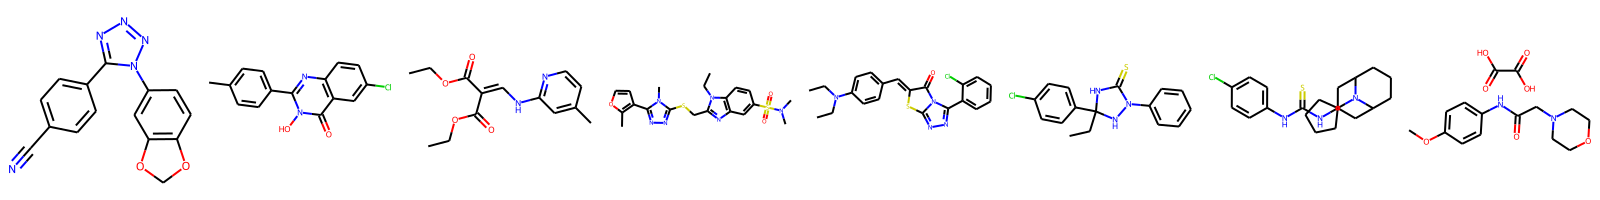

In [81]:
molno = 10
latent_mol = smiles_to_latent.predict(x_test[molno:molno+1])
#we take the absolute difference between latent vectors as the basis for similarity
sorti = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))

Draw.MolsToImage(smi_test.iloc[sorti[0:8]].apply(Chem.MolFromSmiles))

In [105]:
def latent_to_smiles(latent, char_len):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states.predict(latent)
    test_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char2int["!"]
    
    #NOTE 22 here is the length of the charset! will need to be dynamic!
    samplevec = np.zeros((1,1,char_len))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(50):
        o = test_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int2char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int2char[sampleidx]
            samplevec = np.zeros((1,1,char_len))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles


In [106]:
smiles = latent_to_smiles(x_latent[0:1], len(charset))

1/1 [==============================] - 0s 13ms/step


In [107]:
print(smiles)

CC1=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=CC=C


In [104]:
# try:
mol = Chem.MolFromSmiles(smiles)
print(mol)
# Draw.MolToImage(mol)
# except:
#     print("Failed")

None


In [ ]:
#Above code did not produce meaningful SMILES strings
#attempt simpler method


# Preparing datasets by matching the dataset lengths (dataX will be the SMILES strings and dataY will be individual characters in the SMILE string)
